In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf
from scalebars import *

import balance_configs as configs
# from ei_balance import Model
# from Rig import Rig
import experiments as exps
import analysis as ana

In [2]:
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
# data_path = "/mnt/Data/NEURONoutput/sac_net/committee_runs/"
base_path = "/mnt/Data/NEURONoutput/sac_net/"

## TODO:
- update the synapses to enable poisson quantal input, as in the sac-sac model
- fill out notebook with figures and interactive displays

Average GABA synapse count: 143.48


<IPython.core.display.Javascript object>


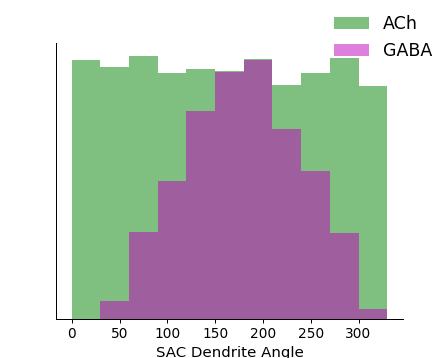

In [21]:
model_config = configs.sac_mode_config(ttx=False)
angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    model_config, n_nets=25, bins=[12], figsize=(5, 4))

In [5]:
model_path = os.path.join(base_path, "model_runs")
save_name = "test"
# load_name = None
load_name = "test"

model_config = configs.sac_mode_config(ttx=False)

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=3,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        pool_sz=8,
    )

t0 = time.time()
with h5.File(os.path.join(model_path, load_name) + ".h5", "r") as pckg:
    d = unpack_hdf(pckg)
print("data unpacked in %.1fs" % (time.time() - t0))
    
# deserialize parameter dicts
for i in d.keys():
    for rho in d[i].keys():
        d[i][rho]["params"] = json.loads(d[i][rho]["params"])
        
# rearrange hierarchy (rho condition above repeats)
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())

data unpacked in 26.7s


In [6]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"]
tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-57)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)

<IPython.core.display.Javascript object>


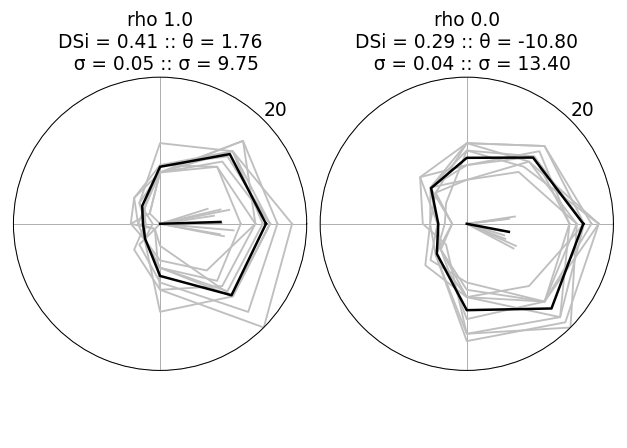

In [7]:
max_spikes = np.max([r["spikes"] for r in metrics.values()])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=int("1%i%i" % (n_cols, loc + 1)),
    )
    for loc, (r, m) in enumerate(metrics.items())
]
polar_fig.tight_layout()

<IPython.core.display.Javascript object>


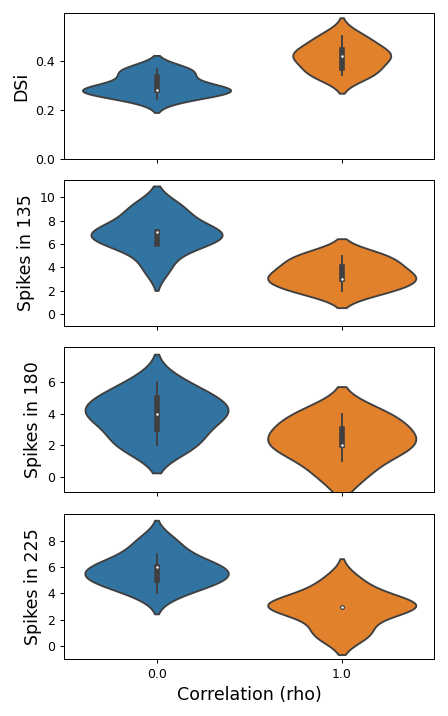

In [8]:
violins = sac_rho_violins(metrics, dir_labels, figsize=(5, 8))

<IPython.core.display.Javascript object>


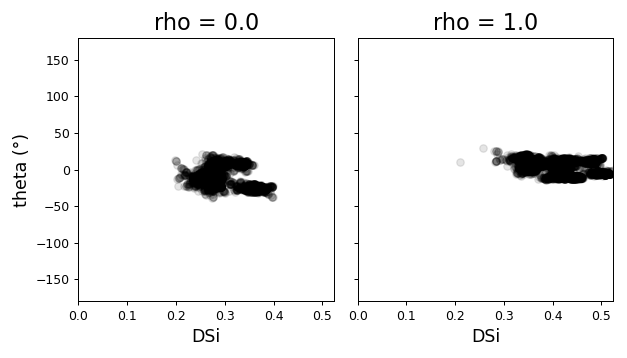

In [9]:
scatter_fig = ds_scatter(tuning, figsize=(7, 4))
scatter_fig.tight_layout()

<IPython.core.display.Javascript object>


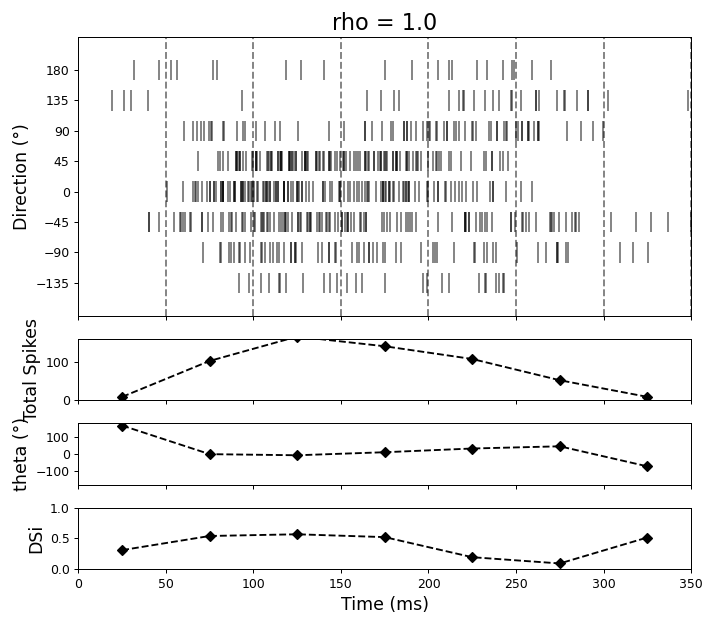

In [10]:
dir_field_offsets = [11.0, 18.8, 37.8, 13.8, 0.8, 19.3, 16.0, 0.0]  # ms
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=1.,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=160,
    figsize=(8, 7),
)

<IPython.core.display.Javascript object>


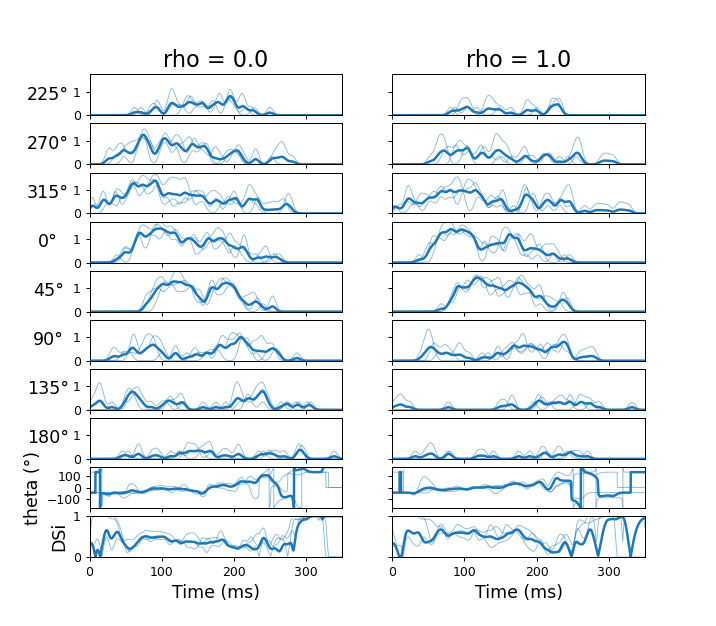

In [11]:
evol = time_evolution(d, dir_labels, kernel_var=45, figsize=(8, 7))

In [12]:
if d[0.0][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rec_locs = d[0.0][0]["dendrites"]["locs"]
    syn_locs = d[0.0][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[0.])
    theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[0.])

<IPython.core.display.Javascript object>


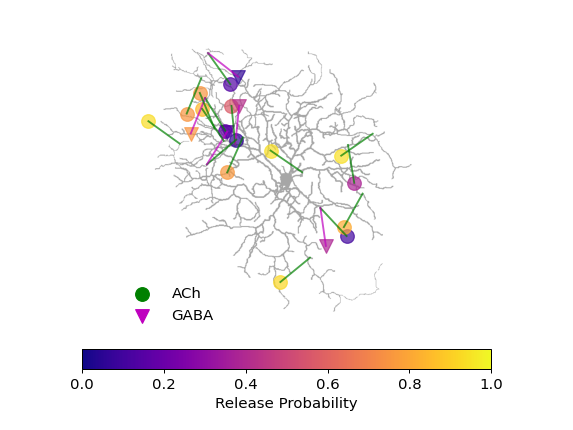

In [14]:
rho = 0.0
net = 0

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    io.imread("assets/dsgc.png")[:, :, 0],
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=0,
    n_syn=15,
)
over_fig.tight_layout()